<a href="https://colab.research.google.com/github/NadAAaHH/SDAIA-T5-NBM_Project/blob/main/Web_Scraping_and_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Step 1:** Importing the libraries

In [ ]:
from bs4 import BeautifulSoup
import requests
import time, os
from selenium.common.exceptions import NoSuchElementException
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
import random
import numpy as np

**Step 2:** Scraping Google to get Linkedin urls

In [ ]:
chromedriver = r"path to the chromedriver executable" 
os.environ["webdriver.chrome.driver"] = chromedriver
driver = webdriver.Chrome(chromedriver)

In [ ]:
driver.get('https://google.com')
time.sleep(2)

In [ ]:
search_query = driver.find_element_by_name('q')
search_query.send_keys('site:linkedin.com/in/')
time.sleep(1)

In [ ]:
search_query.submit()
time.sleep(2.5)

In [ ]:
lst = []

In [ ]:
def getUrls(n):
    while len(urls) < n:  
        soup = BeautifulSoup(driver.page_source, 'html.parser')
        tags = soup.find_all('div', class_='yuRUbf')
        urls.append([tag.find('a').get('href') for tag in tags])
        time.sleep(np.random.uniform(10, 20))
        next_btn = driver.find_element_by_xpath('/html/body/div[7]/div/div[9]/div[1]/div/div[6]/span[1]/table/tbody/tr/td[12]/a/span[2]/span')
        next_btn.click();
    flat_list = [j for i in urls for j in i]
    return flat_list

In [ ]:
# specify the number of urls you want to get (e.g. passing 2 will return 20 url)
lst.append(getUrls(2))
lst = list(lst[0])

In [ ]:
# save the urls into a file
textfile = open("urls.txt", "w")

for i in lst:
    textfile.write(i + "\n")
textfile.close()

In [ ]:
driver.quit()

**Step 3:** Scraping Linkedin to get the data

In [ ]:
chromedriver = r"path to the chromedriver executable" 
os.environ["webdriver.chrome.driver"] = chromedriver
driver = webdriver.Chrome(chromedriver)

In [ ]:
def login_to_linkedin(username, password):
    url = "https://www.linkedin.com/login?"
    driver.get(url)
    time.sleep(1)
    
    username_box = driver.find_element_by_xpath('/html/body/div/main/div[2]/div[1]/form/div[1]/input')
    username_box.send_keys(username)

    password_box = driver.find_element_by_xpath('/html/body/div/main/div[2]/div[1]/form/div[2]/input')
    password_box.send_keys(password)

    # hit enter
    enter_btn = driver.find_element_by_xpath('/html/body/div/main/div[2]/div[1]/form/div[3]/button')
    enter_btn.click()

    time.sleep(1)

In [ ]:
# linkedin login credentials
login_to_linkedin('username', 'password')

In [ ]:
import pandas as pd

In [ ]:
df = pd.DataFrame(columns = ["total_followers", "posted_since", "total_posts", "likes"])

In [ ]:
def get_posts(df, profile_url):
    
    # define an empty dictionary to be filled later
    dict_row = {"total_followers": None, "posted_since": None, "total_posts": None, "likes": None}
    
    # go to profile page
    driver.get(profile_url);
    time.sleep(2)
    
    # smooth scroll 
    scheight = .1
    while scheight < 9:
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight/%s);" % scheight)
        scheight += .01
    
    # get the number of followers
    soup = BeautifulSoup(driver.page_source, 'html.parser')
    total_followers = soup.find('span', class_='align-self-center t-14 t-black--light').text.split()[0]
    time.sleep(5)
    
    # direct to posts page
    get_posts = profile_url + "/detail/recent-activity/shares/".replace(' ', '+')
    driver.get(get_posts);
    time.sleep(5)
    
    # smooth scroll
    scheight = 6
    while scheight > 1.5:
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight/%s);" % scheight)
        scheight -= .1
            
    # scroll to the end of posts
    try:
        while driver.find_element_by_css_selector("button.artdeco-button.artdeco-button--muted.artdeco-button--1.artdeco-button--full.artdeco-button--secondary.ember-view"):
            time.sleep(1)
            scheight = 6
            while scheight > 1.5:
                driver.execute_script("window.scrollTo(0, document.body.scrollHeight/%s);" % scheight)
                scheight -= .1
            time.sleep(2)       
            # scroll to last post
            if driver.find_element_by_css_selector("button.artdeco-button.artdeco-button--muted.artdeco-button--1.artdeco-button--full.artdeco-button--secondary.ember-view"):
                element = driver.find_element_by_css_selector("button.artdeco-button.artdeco-button--muted.artdeco-button--1.artdeco-button--full.artdeco-button--secondary.ember-view")
                driver.execute_script("arguments[0].click();", element)
            
    except NoSuchElementException:
        pass
    
    
    soup = BeautifulSoup(driver.page_source, 'html.parser')
    # get how old each post is
    lst_howold = []
    for tag in soup.find_all('span', class_='feed-shared-actor__sub-description t-12 t-normal t-black--light'):
        for i in tag.find_all('span', class_="visually-hidden"):
            # to exclude inner posts
            if i.parent.parent.parent.parent.parent.parent.get('class') == None:
                lst_howold.append(i.text)
                        
    # get the number of likes of each post
    lst_reactions = []
    lst_reactions = [i.text for i in soup.find_all('span', class_='v-align-middle social-details-social-counts__reactions-count')]
            
    # get the total number of posts
    total_posts = len(lst_reactions)
    
    time.sleep(5)
    
    # fill the dictionary with the collected data
    if lst_howold:
        for date, like in zip(lst_howold, lst_reactions):
            dict_row['total_followers'] = total_followers
            dict_row['total_posts'] = total_posts
            dict_row['posted_since'] = date
            dict_row['likes'] = like
            df = df.append(dict_row, ignore_index=True)
    return df

In [ ]:
# reading collected linkedin urls
my_file = open(r"urls.txt", "r")
LinkedIn_profiles = my_file.readlines()

In [ ]:
# pass urls to function (specify the number of profiles you want to scrape in range
for i in range(4,7):
    returned_df = get_posts(df, LinkedIn_profiles[i][:-1])
    print(returned_df)
    returned_df.to_csv (r'profiles.csv', index = None, header=True, mode='a')

Empty DataFrame
Columns: [total_followers, posted_since, total_posts, likes]
Index: []
  total_followers posted_since total_posts likes
0             996  3 years ago           1    22
Empty DataFrame
Columns: [total_followers, posted_since, total_posts, likes]
Index: []


In [ ]:
driver.quit()

**Step 4:** Preparing the dataset

In [ ]:
df = pd.read_csv('profiles.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1753 entries, 0 to 1752
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   total_followers  1753 non-null   object
 1   posted_since     1753 non-null   object
 2   total_posts      1753 non-null   object
 3   likes            1753 non-null   object
dtypes: object(4)
memory usage: 54.9+ KB


In [ ]:
# drop nonnumerical rows and reset index
df.drop(df[df.total_followers == 'total_followers'].index, inplace=True)
df.reset_index(drop=True, inplace=True)

In [ ]:
# convert all time units to days
for i, row in df.iterrows():
    if 'year' in row.posted_since:
        df.at[i,'posted_since'] = int(row.posted_since[0]) * 365
    elif 'month' in row.posted_since:
        df.at[i,'posted_since'] = int(row.posted_since[0]) * 30
    elif 'day' in row.posted_since:
        df.at[i,'posted_since'] = int(row.posted_since[0])
    elif 'week' in row.posted_since:
        df.at[i,'posted_since'] = int(row.posted_since[0]) * 7
    elif 'hour' in row.posted_since:
        df.at[i,'posted_since'] = int(row.posted_since[0]) * 0.0416666667

In [ ]:
df.dtypes

total_followers    object
posted_since       object
total_posts        object
likes              object
dtype: object

In [ ]:
# removing commas from numbers
for i, row in df.iterrows():
    df.at[i,'total_followers'] = row.total_followers.replace(',', '')
    df.at[i,'likes'] = row.likes.replace(',', '')

In [ ]:
# converting all columns to numeric types
for i in df.columns:
    df[i] = pd.to_numeric(df[i])

In [ ]:
df.dtypes

total_followers      int64
posted_since       float64
total_posts          int64
likes                int64
dtype: object

In [ ]:
df.head()

,total_followers,posted_since,total_posts,likes
0,1200,1460.0,2,4
1,1200,1460.0,2,1
2,5013,7.0,39,7
3,5013,7.0,39,33
4,5013,7.0,39,13


In [ ]:
df.describe()

,total_followers,posted_since,total_posts,likes
count,1706.000000,1706.000000,1706.000000,1706.000000
mean,59989.138335,360.555906,200.209848,62.476553
std,99825.127012,338.706635,163.260005,115.199680
min,203.000000,0.375000,1.000000,1.000000
25%,2924.000000,120.000000,37.000000,6.000000
50%,7225.000000,365.000000,133.000000,21.000000
75%,13315.500000,365.000000,358.000000,68.000000
max,240837.000000,2555.000000,398.000000,1506.000000


**Step 5:** Building the model

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LogisticRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_union
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

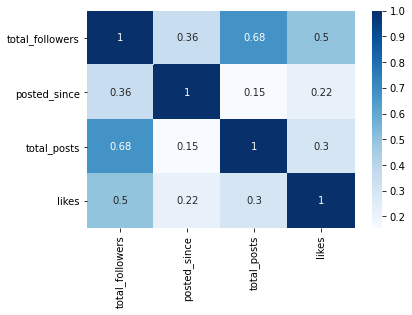

In [ ]:
sns.heatmap(df.corr(), annot=True, cmap = "Blues");

In [ ]:
# separate features from target
X = df[['total_followers', 'posted_since', 'total_posts']]
y = df.likes

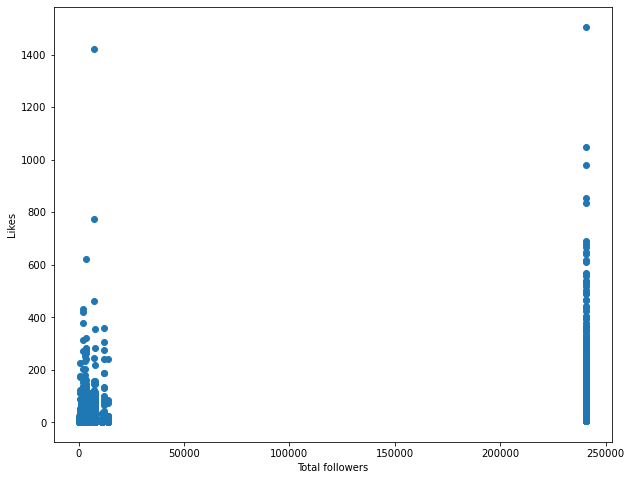

In [ ]:
# plot the target with the total number of followers feature
plt.figure(figsize=(10, 8))
plt.scatter(X.total_followers , y)
plt.ylabel('Likes')
plt.xlabel('Total followers')
plt.savefig('With_outliers.png', transparent = False)
plt.show()

In [ ]:
# exclude outliers
c = X.total_followers[X.total_followers < 10000]

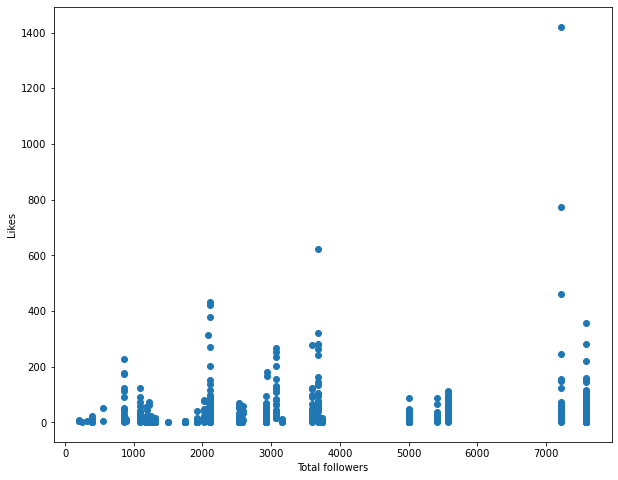

In [ ]:
plt.figure(figsize=(10, 8))
plt.scatter(X.total_followers[c.index] , y[c.index])
plt.ylabel('Likes')
plt.xlabel('Total followers')
plt.savefig('Without_outliers.png', transparent = False)
plt.show()

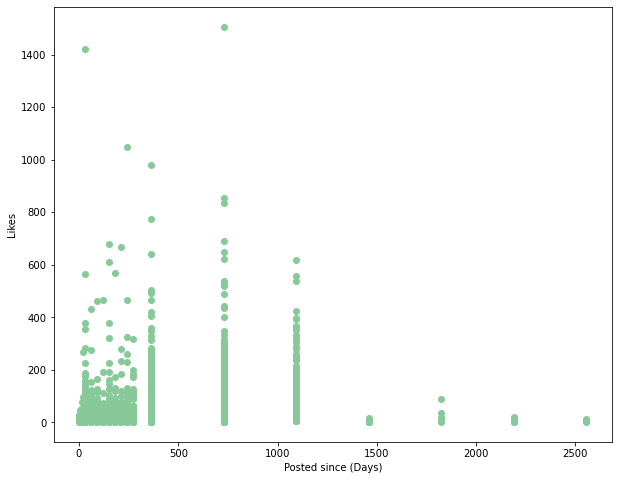

In [ ]:
# plot the target with the posted since feature
plt.figure(figsize=(10, 8))
plt.scatter(X.posted_since , y, color = '#88c999')
plt.ylabel('Likes')
plt.xlabel('Posted since (Days)')
plt.savefig('plt2.png', transparent = False)
plt.show()

In [ ]:
# splitting the data to 70% train - 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
# build a Linear regression model
m = LinearRegression()
m.fit(X_train, y_train)
print('Accuracy:', m.score(X_test, y_test))
print('Mean Absolute Error:', mean_absolute_error(m.predict(X_test), y_test))  

Accuracy: 0.20309526074697615
Mean Absolute Error: 51.26529347630574


In [ ]:
# Experiment 1: try a Linear regression model with polynomial features with degree = 3
poly = PolynomialFeatures(degree=3)
X_train_poly = poly.fit_transform(X_train)

# Apply polynomial transformation to val set
X_test_poly = poly.transform(X_test)

# Fit a model using polynomial features
lr_poly = LinearRegression()
lr_poly.fit(X_train_poly,y_train)
print('Accuracy:', lr_poly.score(X_test_poly,y_test))
print('Mean Absolute Error:', mean_absolute_error(lr_poly.predict(X_test_poly), y_test))  

Accuracy: 0.22932063028130178
Mean Absolute Error: 49.47831002814044


In [ ]:
# Experiment 2: try different regularization models while selecting the best alpha 
alphas = np.linspace(0.001, 1, 100)
kf = KFold(7, random_state=0, shuffle=True)
params = {'alpha':alphas}
gs = GridSearchCV(ElasticNet(), param_grid=params, cv=kf)
m = gs.fit(X_train, y_train)
print('Accuracy:', m.score(X_test, y_test))
print('Mean Absolute Error:', mean_absolute_error(m.predict(X_test), y_test))  

Accuracy: 0.20309116820311246
Mean Absolute Error: 51.265400802503166
